# **Import needed libraries**

In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the Dataset**


In [ ]:
#Read the training dataset into the dataframe
# Generate data paths with labels
train_data_dir = r"C:\Users\SSD\Desktop\brain_tumour_data\Training"
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
train_df

,filepaths,labels
0,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,glioma
1,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,glioma
2,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,glioma
3,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,glioma
4,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,glioma
...,...,...
5707,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,pituitary
5708,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,pituitary
5709,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,pituitary
5710,C:\Users\SSD\Desktop\brain_tumour_data\Trainin...,pituitary


In [ ]:
# read the testing dataset into the dataframe
# Generate data paths with labels
test_data_dir = r"C:\Users\SSD\Desktop\brain_tumour_data\Testing"
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

ts_df = pd.concat([Fseries, Lseries], axis= 1)


In [5]:
ts_df

,filepaths,labels
0,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,glioma
1,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,glioma
2,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,glioma
3,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,glioma
4,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,glioma
...,...,...
1306,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,pituitary
1307,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,pituitary
1308,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,pituitary
1309,C:\Users\SSD\Desktop\brain_tumour_data\Testing...,pituitary


# **Data preprocessing**



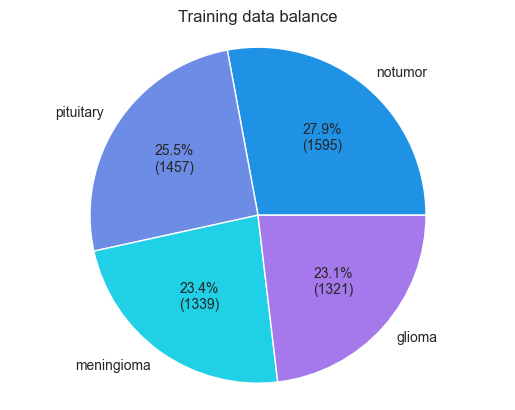

In [ ]:
#first we will check if the training data is balanced or not
data_balance = train_df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6","#A579EB"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

**data is balanced.**



In [7]:
# now we will split the testing data to test and validation data
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [ ]:
#Create image data generator
#this step to convert these dataframes to numpy array
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


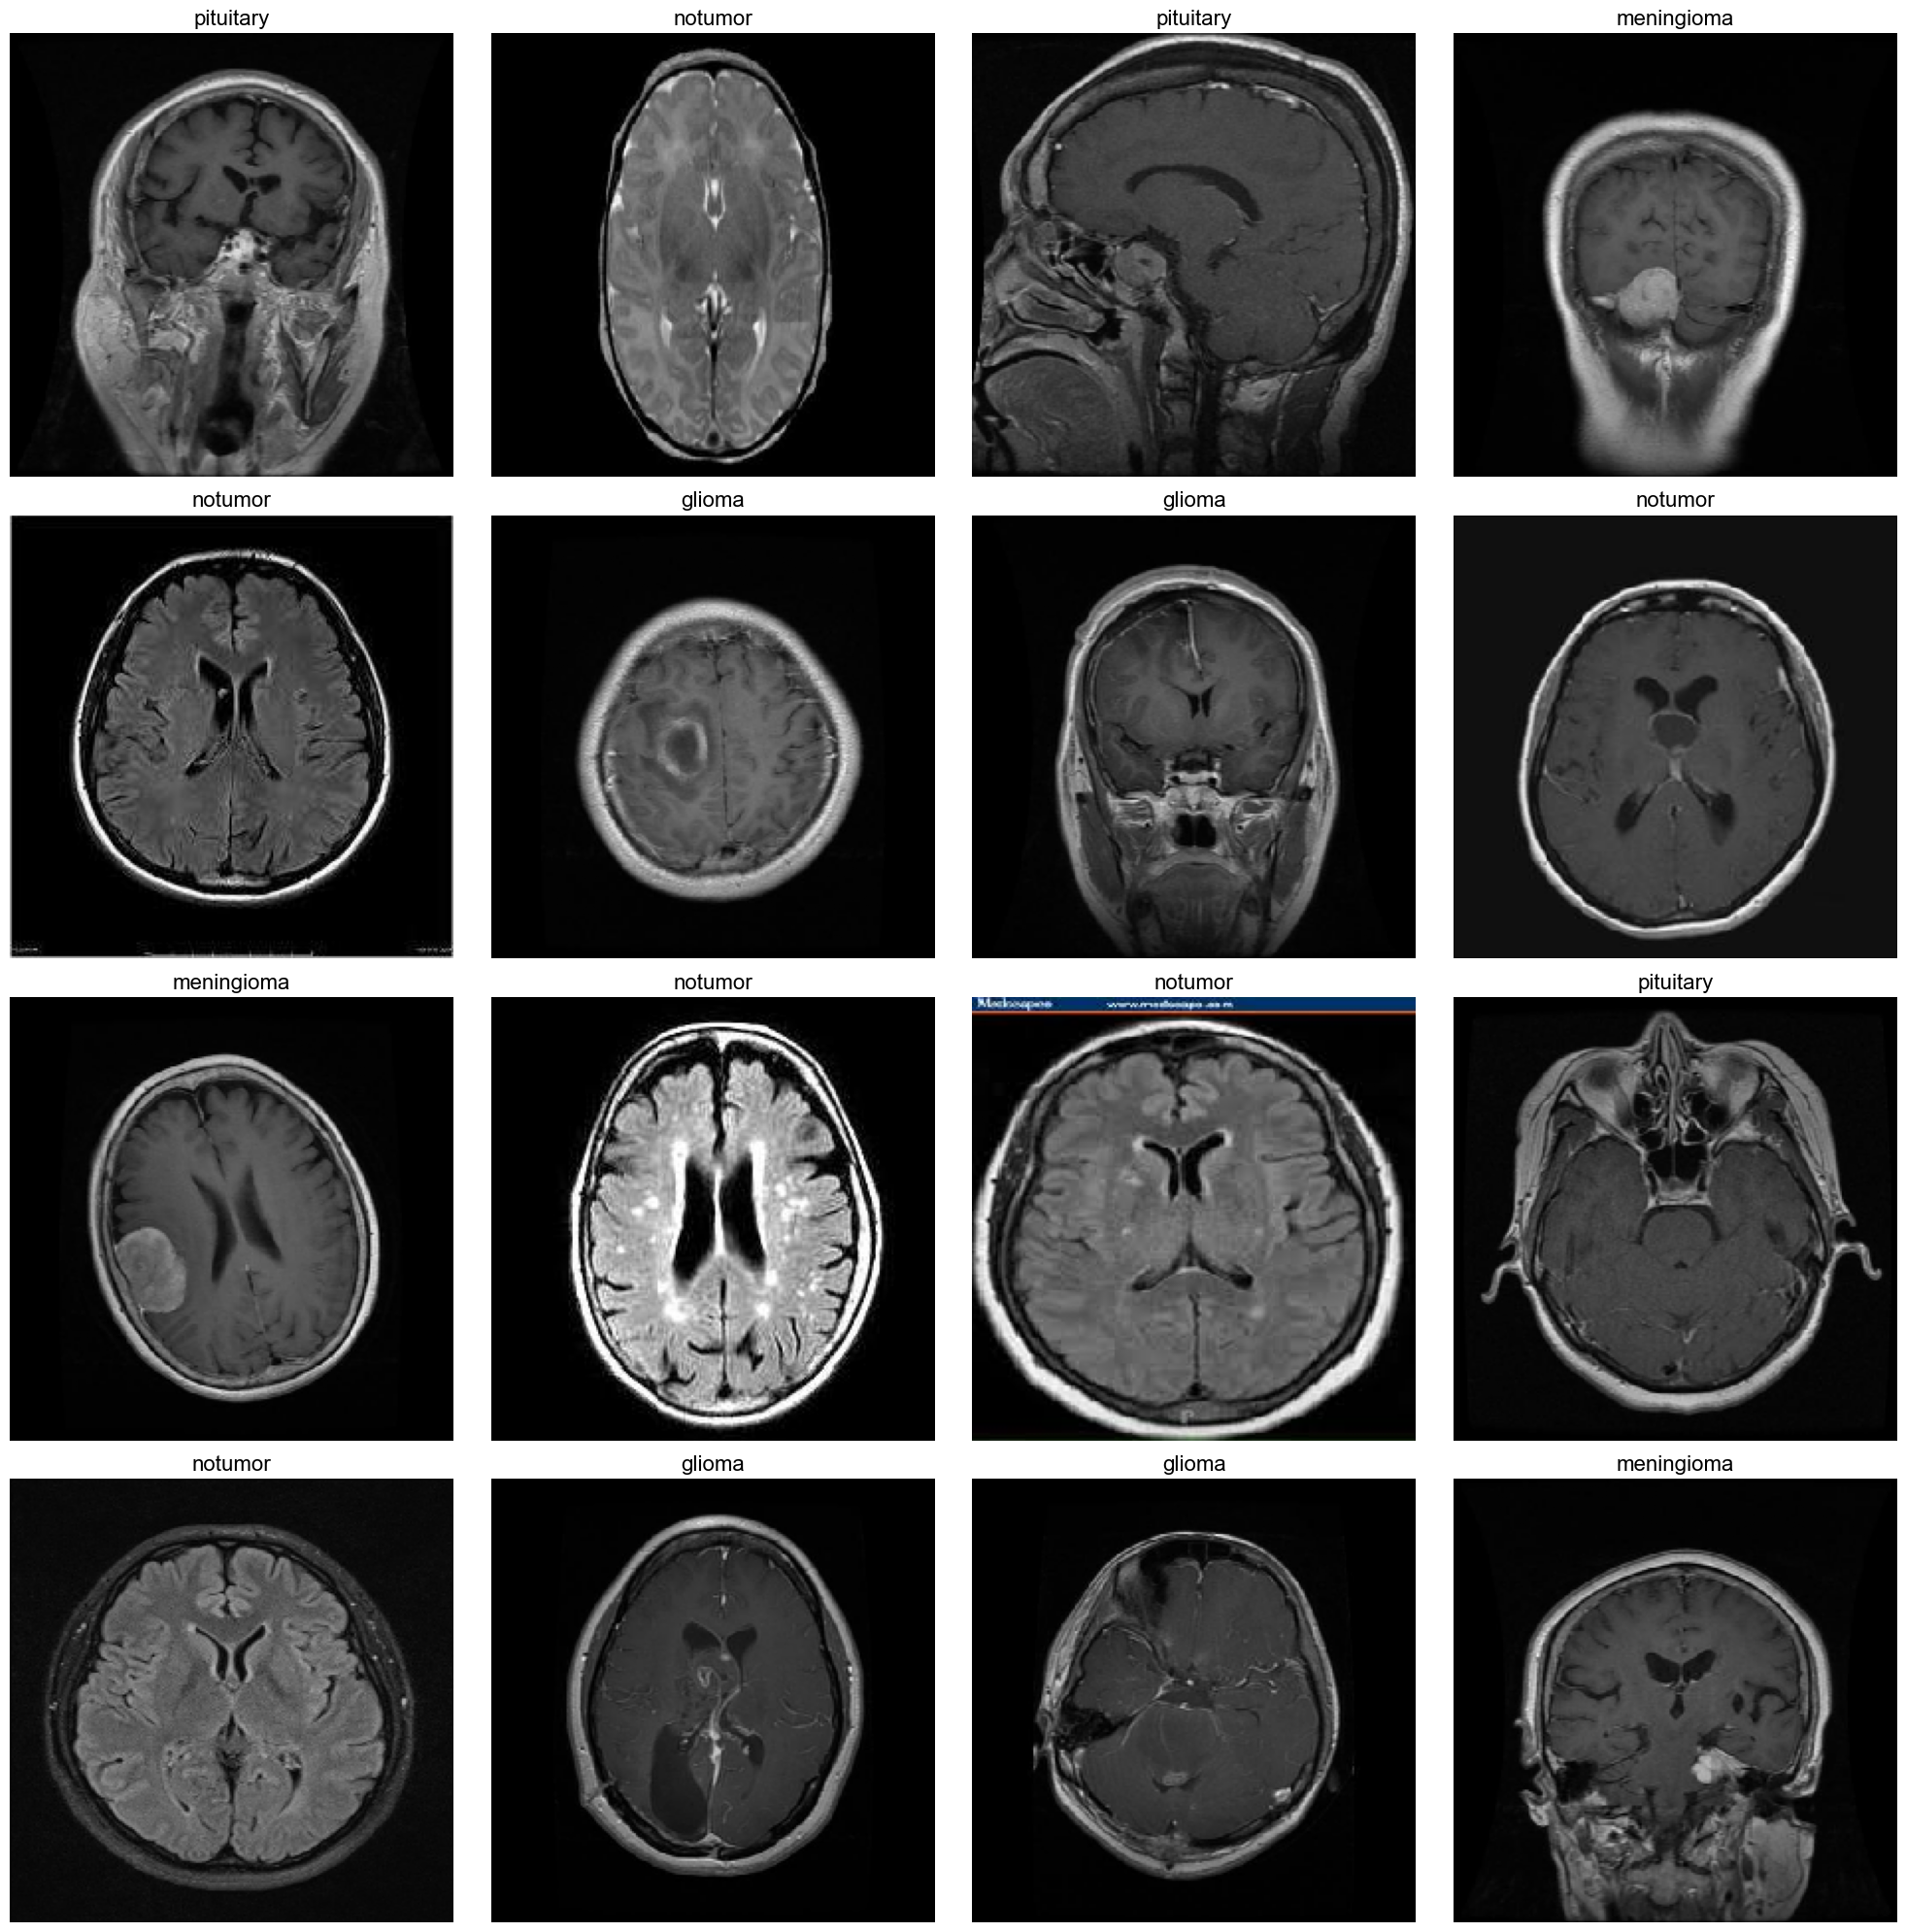

In [ ]:
#Display sample from train data
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())      
images, labels = next(train_gen)      

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **CNN Model**

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
model.add(MaxPooling2D())
    
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D())
    
model.add(Flatten())
    
model.add(Dense(64,activation = "relu",kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32,activation = "relu",kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(class_count, activation = "softmax"))




In [12]:
# Compile model
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,866,724 (49.08 MB)

 Trainable params: 12,866,724 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 260s 720ms/step - accuracy: 0.3186 - loss: 33.0565 - val_accuracy: 0.4198 - val_loss: 2.7335
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 232s 649ms/step - accuracy: 0.3505 - loss: 2.7291 - val_accuracy: 0.4382 - val_loss: 2.3910
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 186s 521ms/step - accuracy: 0.4230 - loss: 2.5433 - val_accuracy: 0.7344 - val_loss: 2.0676
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 216s 605ms/step - accuracy: 0.5368 - loss: 2.2515 - val_accuracy: 0.7939 - val_loss: 1.8285
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 223s 624ms/step - accuracy: 0.6250 - loss: 2.0000 - val_accuracy: 0.8336 - val_loss: 1.6594
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 217s 608ms/step - accuracy: 0.6839 - loss: 1.7941 - val_accuracy: 0.8962 - val_loss: 1.4349
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 235s 658ms/step - accuracy: 0.7360 - loss: 1.5933 - val_accuracy: 0.8351 - val_loss: 1.3034
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 205s 574ms/step - accuracy: 0.7791 

# **MLP MODEL**

In [ ]:
model2 = Sequential([
    Flatten(input_shape=img_shape),  
    Dense(128, activation='relu'),   
    BatchNormalization(),            
    Dense(64, activation='relu'),    
    BatchNormalization(),            
    Dropout(0.5),                    
    Dense(32, activation='relu'),    
    Dropout(0.5),                    
    Dense(class_count, activation='softmax')  
])


model2.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  
                               restore_best_weights=True, 
                               verbose=1)


# Train the model
history2 = model2.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen,callbacks=[early_stopping], shuffle=False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 94s 246ms/step - accuracy: 0.4205 - loss: 1.6942 - val_accuracy: 0.6122 - val_loss: 1.0150
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 95s 265ms/step - accuracy: 0.5768 - loss: 1.1140 - val_accuracy: 0.6779 - val_loss: 0.7786
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 88s 246ms/step - accuracy: 0.6470 - loss: 0.9119 - val_accuracy: 0.7664 - val_loss: 0.6583
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 81s 227ms/step - accuracy: 0.6882 - loss: 0.8038 - val_accuracy: 0.7802 - val_loss: 0.6005
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 83s 233ms/step - accuracy: 0.7336 - loss: 0.7259 - val_accuracy: 0.7756 - val_loss: 0.6504
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 82s 229ms/step - accuracy: 0.7236 - loss: 0.7147 - val_accuracy: 0.7481 - val_loss: 0.7740
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 89s 250ms/step - accuracy: 0.7591 - loss: 0.6384 - val_accuracy: 0.8275 - val_loss: 0.5419
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 93s 261ms/step - accuracy: 0.7795 - loss: 0

In [18]:
# Print model summary
model2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,836,078 (220.63 MB)

 Trainable params: 19,278,564 (73.54 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 38,557,130 (147.08 MB)

# **VGG16 MODEL**

In [ ]:
# Load the VGG16 model without the top (fully connected) layers
vgg_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=img_shape)

vgg_base.trainable = False

model3 = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

model3.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history3 = model3.fit(train_gen, epochs=10, verbose=1, validation_data=valid_gen, shuffle=False)



Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1887s 5s/step - accuracy: 0.7725 - loss: 13.2516 - val_accuracy: 0.9344 - val_loss: 0.4592
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1863s 5s/step - accuracy: 0.9676 - loss: 0.1509 - val_accuracy: 0.9389 - val_loss: 0.2844
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1687s 5s/step - accuracy: 0.9754 - loss: 0.1135 - val_accuracy: 0.9664 - val_loss: 0.1891
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1858s 5s/step - accuracy: 0.9795 - loss: 0.0915 - val_accuracy: 0.9679 - val_loss: 0.1820
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1669s 5s/step - accuracy: 0.9894 - loss: 0.0439 - val_accuracy: 0.9359 - val_loss: 0.3941
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1661s 5s/step - accuracy: 0.9802 - loss: 0.0886 - val_accuracy: 0.9664 - val_loss: 0.2357
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1654s 5s/step - accuracy: 0.9935 - loss: 0.0299 - val_accuracy: 0.9634 - val_loss: 0.2951
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1654s 5s/step - accuracy: 0.9911 - loss: 0.0419 -

In [19]:
# Print model summary
model3.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,986,126 (129.65 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,847,626 (49.01 MB)

# **EFFICIENTNETB0 MODEL**

In [ ]:

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

img_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))

# Load EfficientNetB0 model without the top layers
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_shape)

fine_tune_at = 200
for layer in efficientnet_base.layers[:fine_tune_at]:
    layer.trainable = False
for layer in efficientnet_base.layers[fine_tune_at:]:
    layer.trainable = True

model4 = models.Sequential([
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(class_count, activation='softmax')
])

model4.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Compute class weights to handle class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = dict(enumerate(class_weights))

# Train the model
history4 = model4.fit(
    train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    class_weight=class_weights,
    shuffle=True,
    callbacks=[reduce_lr]
)


Epoch 1/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 278s 698ms/step - accuracy: 0.6374 - loss: 0.9513 - val_accuracy: 0.8534 - val_loss: 0.4105 - learning_rate: 1.0000e-04
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 242s 675ms/step - accuracy: 0.8657 - loss: 0.4151 - val_accuracy: 0.8718 - val_loss: 0.3225 - learning_rate: 1.0000e-04
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 242s 677ms/step - accuracy: 0.8880 - loss: 0.3249 - val_accuracy: 0.8992 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 244s 681ms/step - accuracy: 0.9107 - loss: 0.2645 - val_accuracy: 0.9176 - val_loss: 0.2095 - learning_rate: 1.0000e-04
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 241s 674ms/step - accuracy: 0.9309 - loss: 0.2133 - val_accuracy: 0.9359 - val_loss: 0.1701 - learning_rate: 1.0000e-04
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 241s 674ms/step - accuracy: 0.9271 - loss: 0.2212 - val_accuracy: 0.9496 - val_loss: 0.1411 - learning_rate: 1.0000e-04
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 

## Display Model Performance

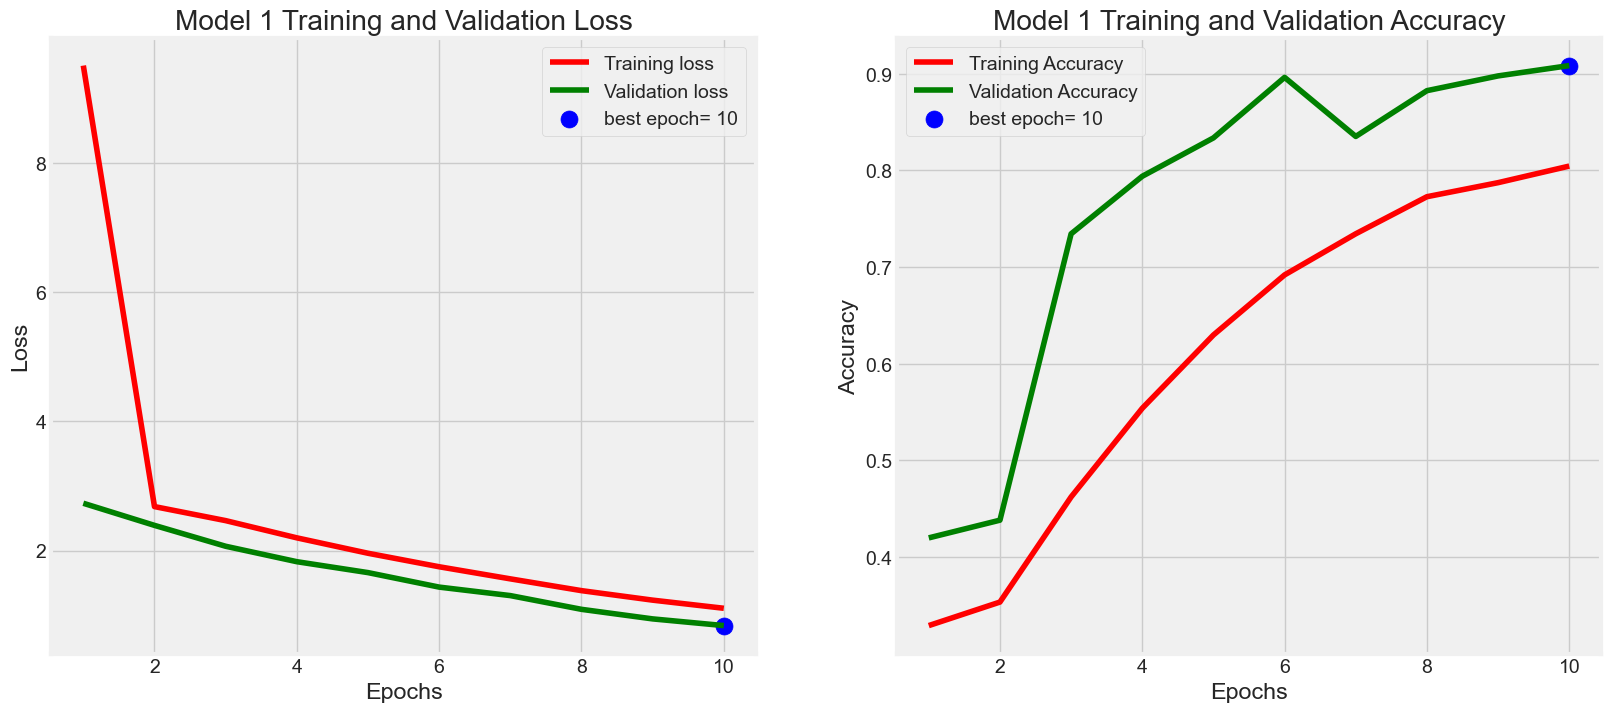

In [20]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Model 1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Model 1 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

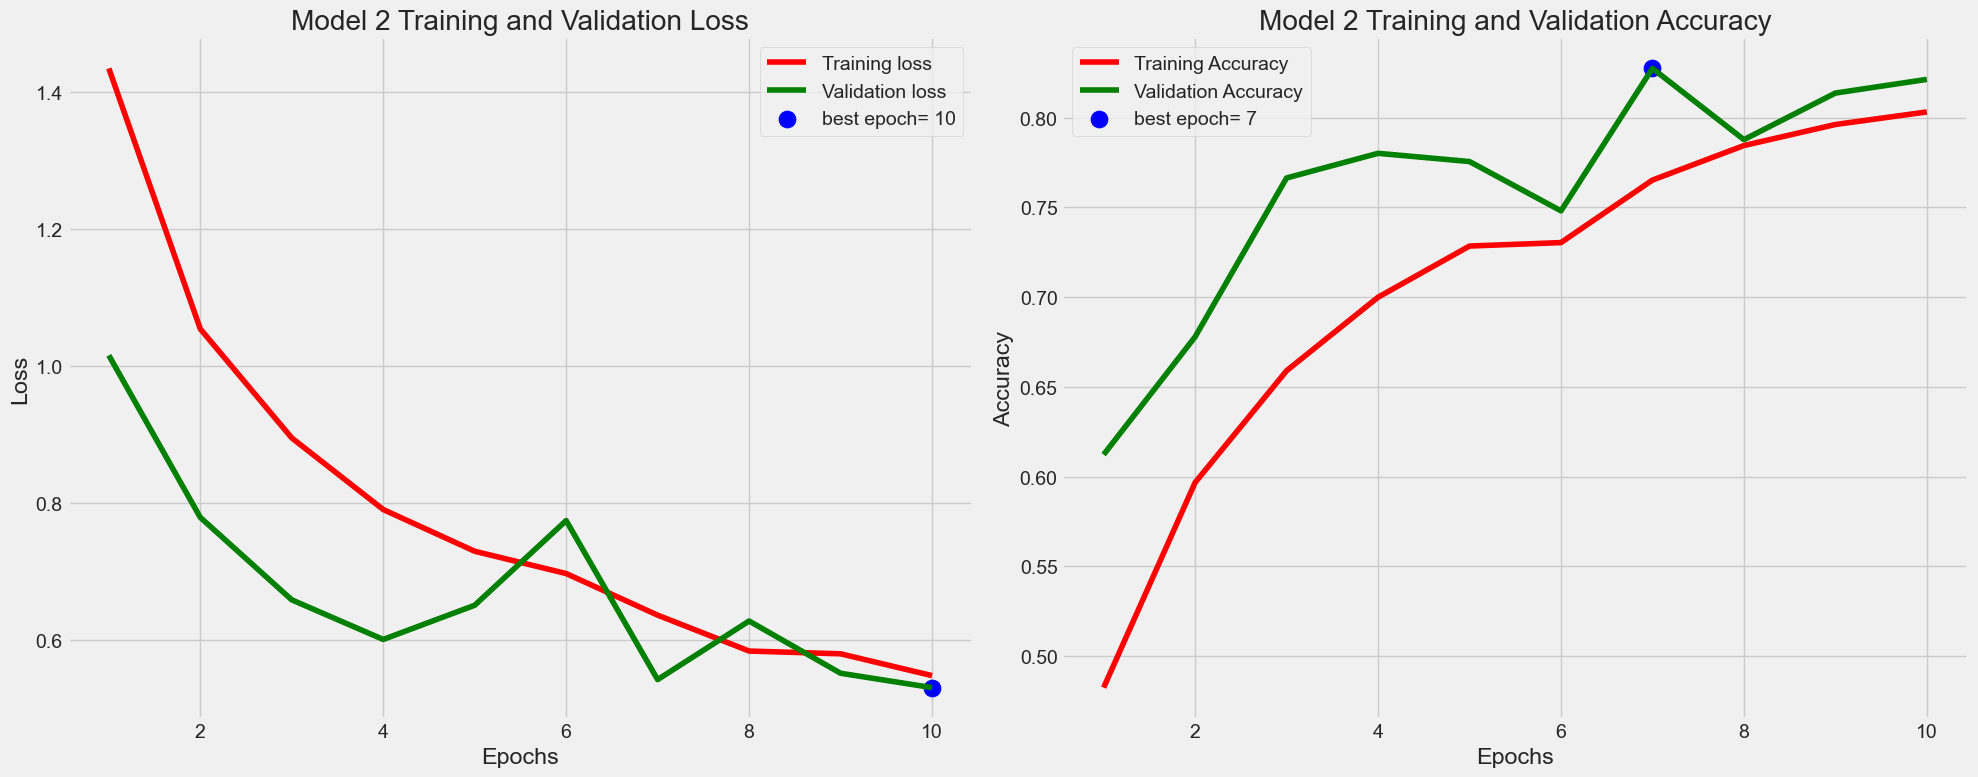

In [21]:
# Define needed variables for model2
tr_acc_model2 = history2.history['accuracy']
tr_loss_model2 = history2.history['loss']
val_acc_model2 = history2.history['val_accuracy']
val_loss_model2 = history2.history['val_loss']
index_loss_model2 = np.argmin(val_loss_model2)
val_lowest_model2 = val_loss_model2[index_loss_model2]
index_acc_model2 = np.argmax(val_acc_model2)
acc_highest_model2 = val_acc_model2[index_acc_model2]

Epochs_model2 = [i+1 for i in range(len(tr_acc_model2))]
loss_label_model2 = f'best epoch= {str(index_loss_model2 + 1)}'
acc_label_model2 = f'best epoch= {str(index_acc_model2 + 1)}'

# Plot training history for model2
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model2, tr_loss_model2, 'r', label='Training loss')
plt.plot(Epochs_model2, val_loss_model2, 'g', label='Validation loss')
plt.scatter(index_loss_model2 + 1, val_lowest_model2, s=150, c='blue', label=loss_label_model2)
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model2, tr_acc_model2, 'r', label='Training Accuracy')
plt.plot(Epochs_model2, val_acc_model2, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model2 + 1, acc_highest_model2, s=150, c='blue', label=acc_label_model2)
plt.title('Model 2 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


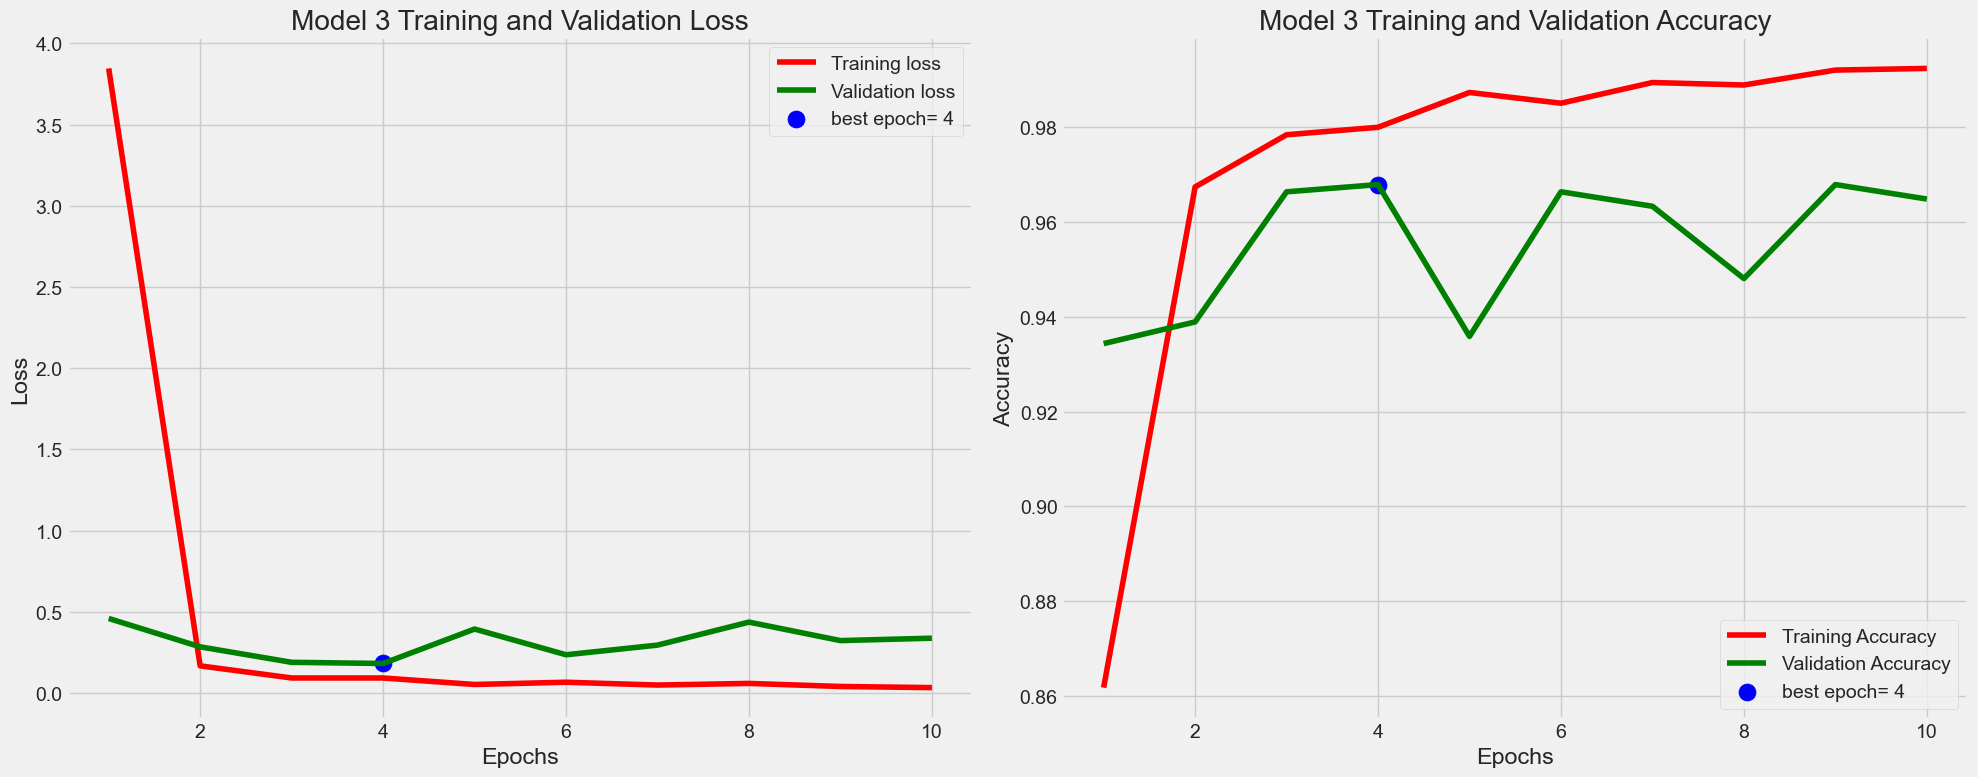

In [22]:
# Define needed variables for model3
tr_acc_model3 = history3.history['accuracy']
tr_loss_model3 = history3.history['loss']
val_acc_model3 = history3.history['val_accuracy']
val_loss_model3 = history3.history['val_loss']
index_loss_model3 = np.argmin(val_loss_model3)
val_lowest_model3 = val_loss_model3[index_loss_model3]
index_acc_model3 = np.argmax(val_acc_model3)
acc_highest_model3 = val_acc_model3[index_acc_model3]

Epochs_model3 = [i+1 for i in range(len(tr_acc_model3))]
loss_label_model3 = f'best epoch= {str(index_loss_model3 + 1)}'
acc_label_model3 = f'best epoch= {str(index_acc_model3 + 1)}'

# Plot training history for model3
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model3, tr_loss_model3, 'r', label='Training loss')
plt.plot(Epochs_model3, val_loss_model3, 'g', label='Validation loss')
plt.scatter(index_loss_model3 + 1, val_lowest_model3, s=150, c='blue', label=loss_label_model3)
plt.title('Model 3 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model3, tr_acc_model3, 'r', label='Training Accuracy')
plt.plot(Epochs_model3, val_acc_model3, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model3 + 1, acc_highest_model3, s=150, c='blue', label=acc_label_model3)
plt.title('Model 3 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


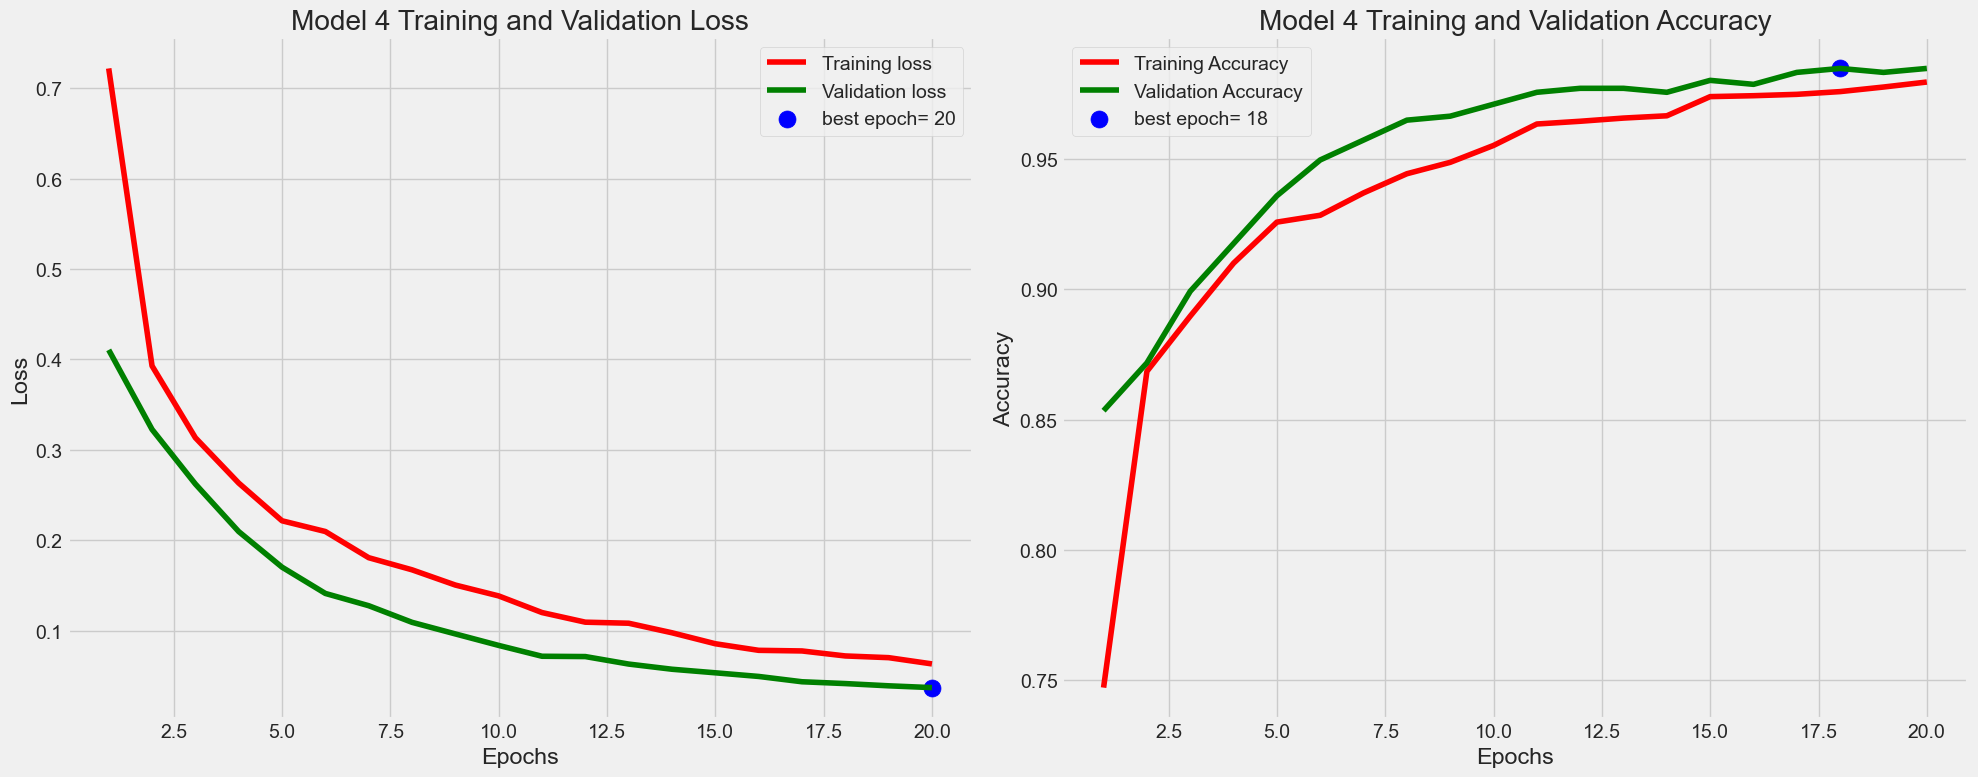

In [23]:
# Define needed variables for model4
tr_acc_model4 = history4.history['accuracy']
tr_loss_model4 = history4.history['loss']
val_acc_model4 = history4.history['val_accuracy']
val_loss_model4 = history4.history['val_loss']
index_loss_model4 = np.argmin(val_loss_model4)
val_lowest_model4 = val_loss_model4[index_loss_model4]
index_acc_model4 = np.argmax(val_acc_model4)
acc_highest_model4 = val_acc_model4[index_acc_model4]

Epochs_model4 = [i+1 for i in range(len(tr_acc_model4))]
loss_label_model4 = f'best epoch= {str(index_loss_model4 + 1)}'
acc_label_model4 = f'best epoch= {str(index_acc_model4 + 1)}'

# Plot training history for model4
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_model4, tr_loss_model4, 'r', label='Training loss')
plt.plot(Epochs_model4, val_loss_model4, 'g', label='Validation loss')
plt.scatter(index_loss_model4 + 1, val_lowest_model4, s=150, c='blue', label=loss_label_model4)
plt.title('Model 4 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_model4, tr_acc_model4, 'r', label='Training Accuracy')
plt.plot(Epochs_model4, val_acc_model4, 'g', label='Validation Accuracy')
plt.scatter(index_acc_model4 + 1, acc_highest_model4, s=150, c='blue', label=acc_label_model4)
plt.title('Model 4 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate Model

In [37]:
##CNN
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 71s 198ms/step - accuracy: 0.9665 - loss: 0.6169
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9044 - loss: 0.7140
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.8859 - loss: 0.7764
Train Loss:  0.6229405403137207
Train Accuracy:  0.9628851413726807
--------------------
Validation Loss:  0.7307108640670776
Validation Accuracy:  0.8931297659873962
--------------------
Test Loss:  0.806081235408783
Test Accuracy:  0.8658536672592163


In [38]:
#MLP 
train_score_model2 = model2.evaluate(train_gen, verbose=1)
valid_score_model2 = model2.evaluate(valid_gen, verbose=1)
test_score_model2 = model2.evaluate(test_gen, verbose=1)

print("Model 2 Train Loss: ", train_score_model2[0])
print("Model 2 Train Accuracy: ", train_score_model2[1])
print('-' * 20)
print("Model 2 Validation Loss: ", valid_score_model2[0])
print("Model 2 Validation Accuracy: ", valid_score_model2[1])
print('-' * 20)
print("Model 2 Test Loss: ", test_score_model2[0])
print("Model 2 Test Accuracy: ", test_score_model2[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.8674 - loss: 0.4280
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7919 - loss: 0.4951
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7878 - loss: 0.6687
Model 2 Train Loss:  0.43251627683639526
Model 2 Train Accuracy:  0.8644958138465881
--------------------
Model 2 Validation Loss:  0.5300871729850769
Model 2 Validation Accuracy:  0.7923663854598999
--------------------
Model 2 Test Loss:  0.8475592732429504
Model 2 Test Accuracy:  0.7667682766914368


In [39]:
#VGG16
train_score_model3 = model3.evaluate(train_gen, verbose=1)
valid_score_model3 = model3.evaluate(valid_gen, verbose=1)
test_score_model3 = model3.evaluate(test_gen, verbose=1)

print("Model 3 Train Loss: ", train_score_model3[0])
print("Model 3 Train Accuracy: ", train_score_model3[1])
print('-' * 20)
print("Model 3 Validation Loss: ", valid_score_model3[0])
print("Model 3 Validation Accuracy: ", valid_score_model3[1])
print('-' * 20)
print("Model 3 Test Loss: ", test_score_model3[0])
print("Model 3 Test Accuracy: ", test_score_model3[1])


357/357 ━━━━━━━━━━━━━━━━━━━━ 1768s 5s/step - accuracy: 0.9505 - loss: 0.3492
41/41 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.9073 - loss: 1.2213
41/41 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.9146 - loss: 1.1554
Model 3 Train Loss:  0.36648276448249817
Model 3 Train Accuracy:  0.949404776096344
--------------------
Model 3 Validation Loss:  1.2254858016967773
Model 3 Validation Accuracy:  0.9099236726760864
--------------------
Model 3 Test Loss:  1.2704980373382568
Model 3 Test Accuracy:  0.9085366129875183


In [27]:
#EFFICIENTNETB0 
train_score_model4 = model4.evaluate(train_gen, verbose=1)
valid_score_model4 = model4.evaluate(valid_gen, verbose=1)
test_score_model4 = model4.evaluate(test_gen, verbose=1)

print("Model 4 Train Loss: ", train_score_model4[0])
print("Model 4 Train Accuracy: ", train_score_model4[1])
print('-' * 20)
print("Model 4 Validation Loss: ", valid_score_model4[0])
print("Model 4 Validation Accuracy: ", valid_score_model4[1])
print('-' * 20)
print("Model 4 Test Loss: ", test_score_model4[0])
print("Model 4 Test Accuracy: ", test_score_model4[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 184s 507ms/step - accuracy: 0.9996 - loss: 0.0072
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 509ms/step - accuracy: 0.9913 - loss: 0.0286
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 518ms/step - accuracy: 0.9885 - loss: 0.0404
Model 4 Train Loss:  0.007932944223284721
Model 4 Train Accuracy:  0.9991246461868286
--------------------
Model 4 Validation Loss:  0.037468813359737396
Model 4 Validation Accuracy:  0.989313006401062
--------------------
Model 4 Test Loss:  0.05464839190244675
Model 4 Test Accuracy:  0.9832317233085632


## Get Predictions

In [16]:
#CNN
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step


In [29]:
#MLP
preds_model2 = model2.predict(test_gen)  
y_pred_model2 = np.argmax(preds_model2, axis=1) 


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


In [16]:
#VGG16
preds_model3 = model3.predict(test_gen)  
y_pred_model3 = np.argmax(preds_model3, axis=1) 


41/41 ━━━━━━━━━━━━━━━━━━━━ 234s 6s/step


In [16]:
#efficientnet
preds_model4 = model4.predict(test_gen)  
y_pred_model4 = np.argmax(preds_model4, axis=1) 

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 491ms/step


## Confusion Matrices and Classification report

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step
Length of test_gen.classes (y_true): 656
Length of y_pred: 656


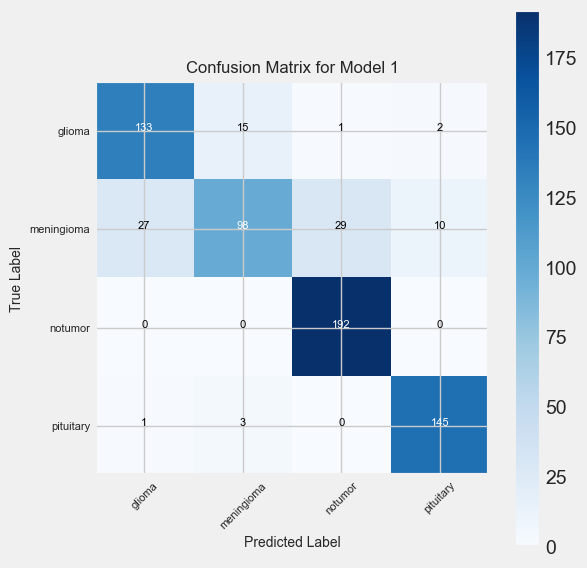

In [ ]:
#CNN
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

y_pred_prob = model.predict(test_gen)  
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = test_gen.classes
print("Length of test_gen.classes (y_true):", len(y_true))
print("Length of y_pred:", len(y_pred))

# If lengths are inconsistent, adjust them
if len(y_true) != len(y_pred):
    min_length = min(len(y_true), len(y_pred))
    y_true = y_true[:min_length]
    y_pred = y_pred[:min_length]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))  
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model 1', fontsize=12)  
plt.colorbar()


tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, fontsize=8)  
plt.yticks(tick_marks, classes, fontsize=8)  

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], 
             horizontalalignment='center', 
             fontsize=8,  
             color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label', fontsize=10)  
plt.xlabel('Predicted Label', fontsize=10)  
plt.show()




41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step


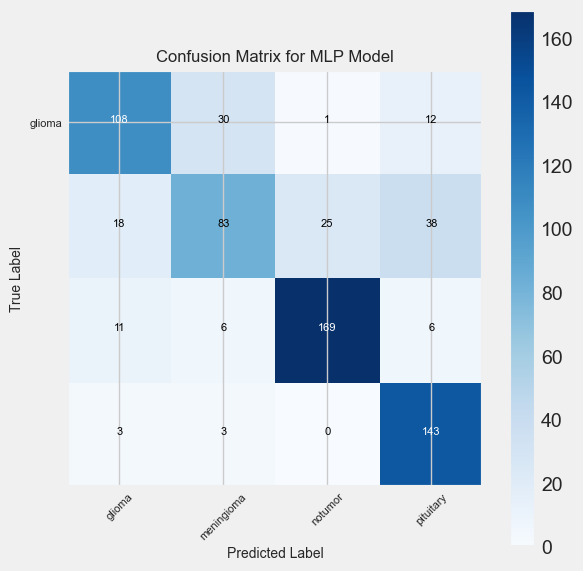

In [ ]:
#   MLP Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.ticker as ticker 

y_pred_model2_probs = model2.predict(test_gen)  
y_pred_model2 = np.argmax(y_pred_model2_probs, axis=1)

# Generate confusion matrix
cm_model2 = confusion_matrix(test_gen.classes, y_pred_model2)


plt.figure(figsize=(6, 6))  
plt.imshow(cm_model2, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for MLP Model', fontsize=12)  
plt.colorbar()


tick_marks_model2 = np.arange(len(classes))  
plt.xticks(tick_marks_model2, classes, rotation=45, fontsize=8)  
plt.yticks(tick_marks_model2, classes, fontsize=8)  

plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(25))  

thresh_model2 = cm_model2.max() / 2.
for i, j in itertools.product(range(cm_model2.shape[0]), range(cm_model2.shape[1])):
    plt.text(j, i, cm_model2[i, j], 
             horizontalalignment='center', 
             fontsize=8,  
             color='white' if cm_model2[i, j] > thresh_model2 else 'black')

plt.tight_layout()
plt.ylabel('True Label', fontsize=10)  
plt.xlabel('Predicted Label', fontsize=10)  


41/41 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step


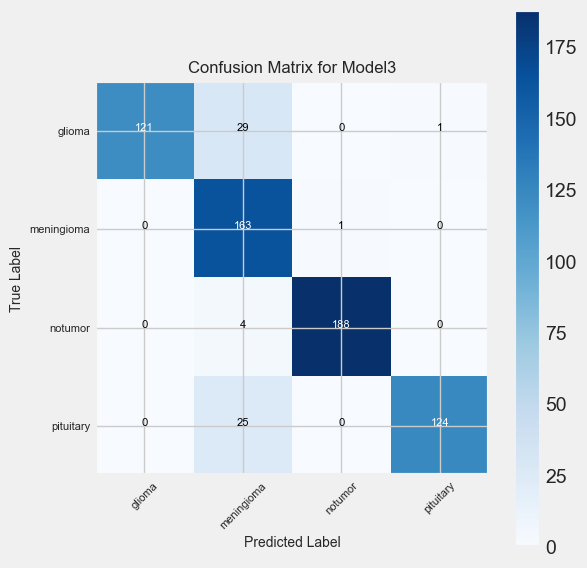

In [ ]:
#VGG16

y_pred_model3_probs = model3.predict(test_gen)  
y_pred_model3 = np.argmax(y_pred_model3_probs, axis=1)

cm_model3 = confusion_matrix(test_gen.classes, y_pred_model3)

plt.figure(figsize=(6, 6))  
plt.imshow(cm_model3, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model3', fontsize=12)  
plt.colorbar()

tick_marks_model3 = np.arange(len(classes_model3))
plt.xticks(tick_marks_model3, classes_model3, rotation=45, fontsize=8)  
plt.yticks(tick_marks_model3, classes_model3, fontsize=8)  


thresh_model3 = cm_model3.max() / 2.
for i, j in itertools.product(range(cm_model3.shape[0]), range(cm_model3.shape[1])):
    plt.text(j, i, cm_model3[i, j], 
             horizontalalignment='center', 
             fontsize=8,  
             color='white' if cm_model3[i, j] > thresh_model3 else 'black')

plt.tight_layout()
plt.ylabel('True Label', fontsize=10)  
plt.xlabel('Predicted Label', fontsize=10)  
plt.show()



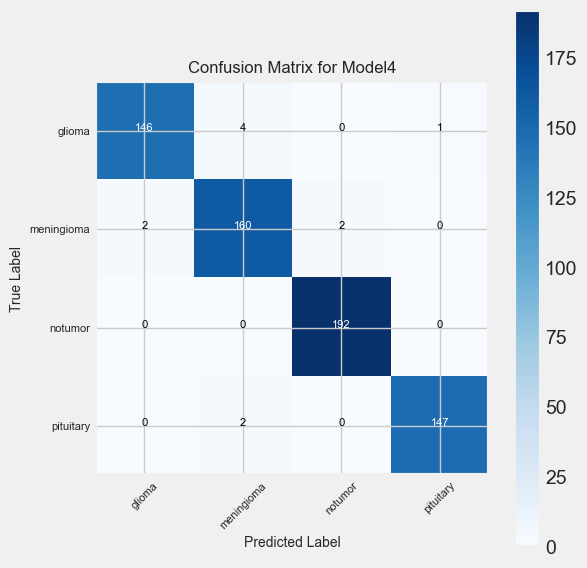

In [ ]:
# #Efficientnetb0

plt.figure(figsize=(6, 6))  
plt.imshow(cm_model4, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model4', fontsize=12)  


tick_marks_model4 = np.arange(len(classes_model4))
plt.xticks(tick_marks_model4, classes_model4, rotation=45, fontsize=8)  
plt.yticks(tick_marks_model4, classes_model4, fontsize=8)

thresh_model4 = cm_model4.max() / 2.
for i, j in itertools.product(range(cm_model4.shape[0]), range(cm_model4.shape[1])):
    plt.text(j, i, cm_model4[i, j],
             horizontalalignment='center',
             fontsize=8,  
             color='white' if cm_model4[i, j] > thresh_model4 else 'black')

plt.tight_layout()
plt.ylabel('True Label', fontsize=10)  
plt.xlabel('Predicted Label', fontsize=10)  
plt.show()


# **Classification Report**

In [49]:
#CNN Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       151
  meningioma       0.96      0.98      0.97       164
     notumor       0.99      1.00      0.99       192
   pituitary       0.99      0.99      0.99       149

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [50]:
#MLP Classificatoin Report
print(classification_report(test_gen.classes, y_pred_model2, target_names= classes_model2))


              precision    recall  f1-score   support

      glioma       0.83      0.88      0.85       151
  meningioma       0.84      0.60      0.70       164
     notumor       0.86      1.00      0.93       192
   pituitary       0.92      0.97      0.95       149

    accuracy                           0.87       656
   macro avg       0.86      0.86      0.86       656
weighted avg       0.86      0.87      0.86       656



In [51]:
#VGG16 Classification Report
print(classification_report(test_gen.classes, y_pred_model3, target_names= classes_model3))


              precision    recall  f1-score   support

      glioma       1.00      0.80      0.89       151
  meningioma       0.74      0.99      0.85       164
     notumor       0.99      0.98      0.99       192
   pituitary       0.99      0.83      0.91       149

    accuracy                           0.91       656
   macro avg       0.93      0.90      0.91       656
weighted avg       0.93      0.91      0.91       656



In [ ]:
# #EFFICIENTNETB0 Classification Report
# Generate classification report
report = classification_report(y_true, y_pred_model4, target_names=classes_model4)
print(report)



              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       151
  meningioma       0.96      0.98      0.97       164
     notumor       0.99      1.00      0.99       192
   pituitary       0.99      0.99      0.99       149

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656

